# Multinomial Class - Logistic Regression
## First level

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from io import StringIO
from _datetime import date

from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import validation_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

In [22]:
# df = pd.read_csv('../01trainingdataset/2021-01-11_datasetFirstLevel.csv')
# df = pd.read_csv('../01trainingdataset/2021-01-20_datasetFirstLevel.csv')
df = pd.read_csv('../../01trainingdataset/dataset/2021-06-06_datasetFirstLevel.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source     546 non-null    object 
 1   condition  546 non-null    object 
 2   fr0        546 non-null    object 
 3   fr1        405 non-null    object 
 4   fr2        405 non-null    object 
 5   fr3        405 non-null    float64
 6   fr4        405 non-null    object 
 7   fr5        405 non-null    object 
 8   fr6        405 non-null    object 
 9   fr7        405 non-null    object 
 10  Sentence   546 non-null    object 
 11  CEsnippet  544 non-null    object 
dtypes: float64(1), object(11)
memory usage: 51.3+ KB


,source,condition,fr0,fr1,fr2,fr3,fr4,fr5,fr6,fr7,Sentence,CEsnippet
0,MAYO,Acute kidney failure,DECLINE,FAST,FROM,1.0,DAY,TO,1,WEEK,Acute kidney failure — also called acute renal...,Acute kidney failure — also called acute renal...
1,MAYO,Systemic mastocytosis,DECLINE,FAST,FROM,1.0,DAY,TO,1,WEEK,"Another type, aggressive systemic mastocytosis...","Another type, aggressive systemic mastocytosis..."
2,MAYO,Plague,DECLINE,FAST,FROM,1.0,DAY,TO,1,WEEK,Pneumonic plague progresses rapidly and may ca...,Pneumonic plague progresses rapidly and may ca...
3,MAYO,Dermatographia,DECLINE,FAST,FROM,1.0,DAY,TO,1,WEEK,"Rarely, dermatographia develops more slowly an...","Rarely, dermatographia develops more slowly an..."
4,NHS,Epiglottitis,DECLINE,FAST,FROM,1.0,DAY,TO,1,WEEK,The symptoms of epiglottitis usually develop q...,The symptoms of epiglottitis usually develop q...


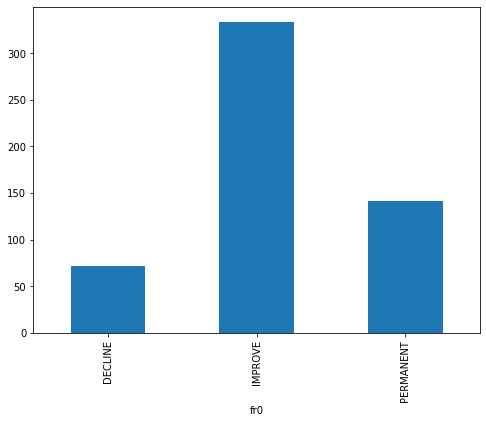

In [23]:
fig = plt.figure(figsize=(8,6))
df.groupby('fr0').Sentence.count().plot.bar(ylim=0)
plt.show()

In [24]:
X = df.Sentence
y = df.fr0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 12)

In [25]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                #('clf', LogisticRegression(n_jobs=1, C=1e3,solver='newton-cg', multi_class='multinomial',max_iter=4000)),
                #('clf', LogisticRegression(n_jobs=1, C=100,solver='liblinear', multi_class='ovr',max_iter=10,class_weight='balanced')),  
                ('clf', LogisticRegression(n_jobs=1, C=1000,solver='newton-cg', multi_class='multinomial',max_iter=1000,class_weight='balanced',random_state=12)),
            ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=1000, class_weight='balanced',
                                    max_iter=1000, multi_class='multinomial',
                                    n_jobs=1, random_state=12,
                                    solver='newton-cg'))])

In [26]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9727272727272728
              precision    recall  f1-score   support

     DECLINE       0.93      0.93      0.93        15
     IMPROVE       0.97      1.00      0.99        67
   PERMANENT       1.00      0.93      0.96        28

    accuracy                           0.97       110
   macro avg       0.97      0.95      0.96       110
weighted avg       0.97      0.97      0.97       110

CPU times: user 14.2 ms, sys: 3.79 ms, total: 18 ms
Wall time: 21.3 ms


In [27]:
newdf = pd.DataFrame({'testSentence': X_test.values})
newdf['testTag'] = y_test.values
newdf['predictedTag'] = y_pred

In [28]:
newdf.testTag.value_counts(dropna=False)

IMPROVE      67
PERMANENT    28
DECLINE      15
Name: testTag, dtype: int64

In [29]:
newdf.predictedTag.value_counts(dropna=False)

IMPROVE      69
PERMANENT    26
DECLINE      15
Name: predictedTag, dtype: int64

In [30]:
newdf.to_csv('02Level1/'+str(date.today())+'LR_testingDataResult.csv', index = True)

FileNotFoundError: [Errno 2] No such file or directory: '02Level1/2021-06-06LR_testingDataResult.csv'

In [31]:
newdf['flag'] = (newdf['testTag'] == newdf['predictedTag'])
flag = [False]
errors = newdf[newdf.flag.isin(flag)]

In [32]:
newdf.flag.value_counts()

True     107
False      3
Name: flag, dtype: int64

# Saving the model

In [34]:
#Save the model
filename = 'models/'+str(date.today())+'_Level1_LR.pkl'
pickle.dump(logreg, open(filename, 'wb'))
# Close the pickle instances
#pickle.close()

In [26]:
!python --version

Python 3.8.5


## Learning curve

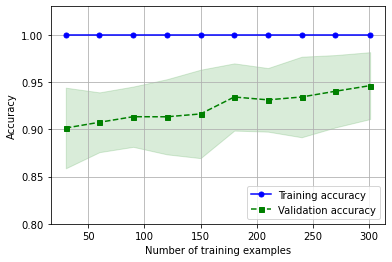

In [35]:
train_sizes, train_scores, test_scores = learning_curve(estimator=logreg, 
                                                        X=X_train,y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
         label='Training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, 
                 color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

## Validation curve

/opt/conda/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/opt/conda/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/opt/conda/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/opt/conda/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/opt/conda/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the

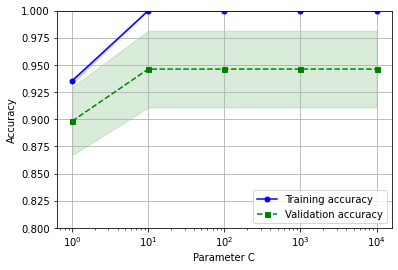

In [34]:
param_range = [1,10,100,1000,10000]
train_scores, test_scores = validation_curve(estimator=logreg,X=X_train,y=y_train,
                                             param_name='clf__max_iter',param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o',markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean,color='green', linestyle='--',marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()